### Hyperparameters:
| Hyperparameter       | Value   |
|----------------------|---------|
| num-filters          | 32      |
| num-bilstm-layer     | 2       |
| output-lstm-dim      | 64      |
| decay-rate           | 0.8     |
| learning-rate        | 0.01    |
| miniBatchSize        | 256     |
| filter-size          | 10 × 1  |
| input-lstm-dim       | 100     |
| L2Regularization     | 0.001   |
| optimizer            | Adam    |
| dropout              | 0.25    |
| maxEpochs            | 500     |

In [3]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..', '..')))

In [4]:
from tqdm import tqdm
import pandas as pd
import numpy as np

import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F

from utils.helper import *

In [5]:
# Device configuration
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print(f"Using device: {device}")

Using device: mps


In [6]:
# Load data
df = pd.read_csv("../../data/Final_Btc_Data_with_Indicators.csv", parse_dates=['Date'])
target_col = "Price"
features = [col for col in df.columns if col not in ["Date", target_col]]

# Scaling + sequence creation (assuming your helper functions already exist)
df = scaled_data(df)
seq_len = 5
horizon = 1
X, y = create_sequences(df[features].values, df[target_col].values, seq_len, horizon)

batch_size = 256
train_loader, val_loader, test_loader = data_loaders(df, X, y, batch_size=batch_size)


/Users/priyanshusekharpanda/Developer/Research Project 1/Bitcoin-price-forecast-main/.venv/lib/python3.12/site-packages/sklearn/base.py:442: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.7.1 when using version 1.7.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [20]:
df

,Date,Price,Open,High,Low,Vol.,Change %,EPU,GPRD,Gold,MA50,EMA50,OBV,MACD,MACD Signal,PSAR
0,2014-04-01,-0.619852,-0.623591,-0.616800,-0.626223,-0.771881,1.013036,-1.079547,0.583055,-0.343253,-0.675750,-0.675218,-1.001312,-0.233187,-0.241462,-0.623429
1,2014-04-02,-0.624188,-0.621492,-0.617565,-0.629553,-0.770160,-2.224378,-1.079547,-0.020825,-0.293792,-0.678356,-0.675421,-1.001985,-0.238152,-0.242506,-0.627906
2,2014-04-03,-0.622868,-0.625858,-0.620967,-0.632176,-0.771671,0.649914,-1.079547,-0.746320,-0.321472,-0.678696,-0.675554,-1.001368,-0.240475,-0.243830,-0.620692
3,2014-04-04,-0.621970,-0.624529,-0.620127,-0.628834,-0.777755,0.404422,-1.079547,-0.832722,-0.236164,-0.678596,-0.675640,-1.000973,-0.241183,-0.245038,-0.620923
4,2014-04-05,-0.620617,-0.623625,-0.619621,-0.626060,-0.783671,0.637128,-1.079547,-0.812042,-0.236164,-0.678210,-0.675659,-1.000795,-0.240097,-0.245776,-0.621149
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3649,2024-03-28,7.175890,7.080750,7.033470,7.324872,-0.484386,0.417208,-0.123370,0.091678,3.912169,7.342725,7.391465,1.642080,3.183304,3.722113,6.432962
3650,2024-03-29,7.077149,7.227825,6.965047,7.340422,-0.541029,-0.390866,-0.123370,0.704501,3.912169,7.408237,7.435519,1.633016,3.154914,3.641858,6.498820
3651,2024-03-30,7.048295,7.127966,6.901976,7.395426,-0.663210,-0.163276,-0.123370,1.520976,3.912169,7.468167,7.476494,1.628427,3.061018,3.557909,6.560726
3652,2024-03-31,7.239089,7.098513,7.014628,7.396784,-0.610427,0.562969,-0.123370,0.560577,3.912169,7.531001,7.524796,1.634949,3.168401,3.513330,6.618917


In [7]:
#CNN–BiLSTM Model Architecture
class CNNBiLSTM(nn.Module):
    def __init__(self, input_dim, num_filters=32, num_bilstm_layers=2, lstm_hidden=64,
                 filter_size=(10, 1), input_lstm_dim=100, dropout_rate=0.25):
        super().__init__()
        self.conv1 = nn.Conv1d(in_channels=input_dim, out_channels=num_filters,
                               kernel_size=filter_size[0], stride=1, padding=filter_size[0] // 2)
        self.proj = nn.Linear(num_filters, input_lstm_dim)
        self.relu = nn.ReLU()
        self.bilstm1 = nn.LSTM(input_size=input_lstm_dim, hidden_size=lstm_hidden,
                               batch_first=True, bidirectional=True)
        self.drop1 = nn.Dropout(dropout_rate)
        self.bilstm2 = nn.LSTM(input_size=2*lstm_hidden, hidden_size=lstm_hidden,
                               batch_first=True, bidirectional=True)
        self.fc = nn.Linear(lstm_hidden * 2, 1)

    def forward(self, x):
        x = x.permute(0, 2, 1)
        x = self.relu(self.conv1(x))
        x = x.permute(0, 2, 1)
        x = self.relu(self.proj(x))
        out, _ = self.bilstm1(x)
        out = self.drop1(out)
        out, _ = self.bilstm2(out)
        out = out[:, -1, :]
        out = self.fc(out)
        return out.squeeze(-1)


In [10]:
#The training + validation function (objective for INFO)
def train_and_validate(params, train_loader, val_loader, device):
    lr = params['lr']
    l2 = params['l2']
    lstm_hidden = int(params['lstm_hidden'])

    model = CNNBiLSTM(input_dim=len(features), lstm_hidden=lstm_hidden,dropout_rate=0.3).to(device)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=l2)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.8)

    num_epochs = 50
    patience = 30
    patience_counter = 0
    best_val_loss = float('inf')

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        for batch_x, batch_y in train_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)

            optimizer.zero_grad()
            outputs = model(batch_x)
            loss = criterion(outputs, batch_y)

            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

            train_loss += loss.item()

        model.eval()
        val_loss = 0
        with torch.no_grad():
            for batch_x, batch_y in val_loader:
                batch_x, batch_y = batch_x.to(device), batch_y.to(device)
                outputs = model(batch_x)
                loss = criterion(outputs, batch_y)
                val_loss += loss.item()
#early stopping
        avg_val_loss = val_loss / len(val_loader)
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter >= patience:
            break
        scheduler.step()

    return best_val_loss


## Implementing the INFO Optimizer
Weighted Mean of Vectors (INFO) algorithm to tune:
- Learning Rate
- L2 Regularization
- LSTM Hidden Units

In [11]:
#INFO Optimizer Implementation
import random

class INFO:
    def __init__(self, bounds, pop_size=6, max_iter=5):
        self.bounds = bounds
        self.pop_size = pop_size
        self.max_iter = max_iter

    def _init_pop(self):
        pop = []
        for _ in range(self.pop_size):
            indiv = {}
            for key, (low, high, typ) in self.bounds.items():
                indiv[key] = random.uniform(low, high) if typ == 'float' else random.randint(low, high)
            pop.append(indiv)
        return pop

    def _clip(self, indiv):
        for k, (low, high, typ) in self.bounds.items():
            if typ == 'int':
                indiv[k] = int(np.clip(round(indiv[k]), low, high))
            else:
                indiv[k] = float(np.clip(indiv[k], low, high))
        return indiv

    def optimize(self, objective_fn):
        pop = self._init_pop()
        fitness = np.array([objective_fn(ind) for ind in pop])
        best_idx = np.argmin(fitness)
        best = pop[best_idx].copy()
        best_score = fitness[best_idx]

        for it in range(self.max_iter):
            weights = 1 / (fitness + 1e-9)
            weights /= np.sum(weights)
            mean_vec = {k: np.sum([weights[i] * pop[i][k] for i in range(self.pop_size)])
                        for k in self.bounds.keys()}

            new_pop, new_fitness = [], []
            for _ in range(self.pop_size):
                cand = {k: mean_vec[k] + np.random.normal(0, 0.1) * (self.bounds[k][1] - self.bounds[k][0])
                        for k in self.bounds.keys()}
                cand = self._clip(cand)
                new_pop.append(cand)
                new_fitness.append(objective_fn(cand))

            new_fitness = np.array(new_fitness)
            for i in range(self.pop_size):
                if new_fitness[i] < fitness[i]:
                    pop[i], fitness[i] = new_pop[i], new_fitness[i]

            best_idx = np.argmin(fitness)
            if fitness[best_idx] < best_score:
                best = pop[best_idx].copy()
                best_score = fitness[best_idx]

            print(f"Iteration {it+1}/{self.max_iter} | Best val_loss: {best_score:.6f}")

        return best, best_score


In [12]:
#bounds and run INFO
bounds = {
    'lr': (5e-5, 3e-3, 'float'),
    'l2': (1e-4, 1e-2, 'float'),
    'lstm_hidden': (32, 128, 'int')
}

def objective(params):
    return train_and_validate(params, train_loader, val_loader, device)

info = INFO(bounds, pop_size=6, max_iter=5)
best_params, best_val_loss = info.optimize(objective)

print("\nBest Parameters Found by INFO:")
print(best_params)
print(f"Best Validation Loss: {best_val_loss:.6f}")


Iteration 1/5 | Best val_loss: 0.225592
Iteration 2/5 | Best val_loss: 0.225592
Iteration 2/5 | Best val_loss: 0.225592
Iteration 3/5 | Best val_loss: 0.213773
Iteration 3/5 | Best val_loss: 0.213773
Iteration 4/5 | Best val_loss: 0.213773
Iteration 4/5 | Best val_loss: 0.213773
Iteration 5/5 | Best val_loss: 0.213773

Best Parameters Found by INFO:
{'lr': 0.0016336773403794586, 'l2': 0.003954594342894821, 'lstm_hidden': 69}
Best Validation Loss: 0.213773
Iteration 5/5 | Best val_loss: 0.213773

Best Parameters Found by INFO:
{'lr': 0.0016336773403794586, 'l2': 0.003954594342894821, 'lstm_hidden': 69}
Best Validation Loss: 0.213773


## 📈 Retrain Final CNN–BiLSTM Model with INFO-Tuned Hyperparameters


In [13]:
# Final training to collect losses for plotting
def final_train(model, train_loader, val_loader, device, optimizer, criterion, num_epochs=100, patience=20):
    train_losses, val_losses = [], []
    best_val_loss = float('inf')
    patience_counter = 0

    for epoch in range(num_epochs):
        model.train()
        total_train, total_val = 0, 0
        for batch_x, batch_y in train_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            optimizer.zero_grad()
            outputs = model(batch_x)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
            total_train += loss.item()

        model.eval()
        with torch.no_grad():
            for batch_x, batch_y in val_loader:
                batch_x, batch_y = batch_x.to(device), batch_y.to(device)
                outputs = model(batch_x)
                loss = criterion(outputs, batch_y)
                total_val += loss.item()

        avg_train_loss = total_train / len(train_loader)
        avg_val_loss = total_val / len(val_loader)
        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)

        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            patience_counter = 0
        else:
            patience_counter += 1

        print(f"Epoch [{epoch+1}/{num_epochs}] - Train: {avg_train_loss:.6f} - Val: {avg_val_loss:.6f}")

        if patience_counter >= patience:
            print("Early stopping triggered.")
            break

    return model, train_losses, val_losses, best_val_loss


In [14]:
# Retrain final INFO-optimized model
final_params = best_params
model = CNNBiLSTM(input_dim=len(features),
                  num_filters=32,
                  num_bilstm_layers=2,
                  lstm_hidden=int(final_params['lstm_hidden']),
                  filter_size=(10, 1),
                  input_lstm_dim=100,
                  dropout_rate=0.25).to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(),
                             lr=final_params['lr'],
                             weight_decay=final_params['l2'])

model, train_losses, val_losses, best_val_loss = final_train(
    model, train_loader, val_loader, device, optimizer, criterion)


Epoch [1/100] - Train: 1.198507 - Val: 20.442098
Epoch [2/100] - Train: 0.876422 - Val: 16.703434
Epoch [3/100] - Train: 0.524549 - Val: 10.319527
Epoch [4/100] - Train: 0.362150 - Val: 4.595203
Epoch [5/100] - Train: 0.167873 - Val: 2.982466
Epoch [3/100] - Train: 0.524549 - Val: 10.319527
Epoch [4/100] - Train: 0.362150 - Val: 4.595203
Epoch [5/100] - Train: 0.167873 - Val: 2.982466
Epoch [6/100] - Train: 0.122481 - Val: 0.402569
Epoch [7/100] - Train: 0.245020 - Val: 3.658910
Epoch [8/100] - Train: 0.085444 - Val: 0.433933
Epoch [6/100] - Train: 0.122481 - Val: 0.402569
Epoch [7/100] - Train: 0.245020 - Val: 3.658910
Epoch [8/100] - Train: 0.085444 - Val: 0.433933
Epoch [9/100] - Train: 0.056776 - Val: 0.860036
Epoch [10/100] - Train: 0.035670 - Val: 0.464366
Epoch [11/100] - Train: 0.027059 - Val: 0.338128
Epoch [9/100] - Train: 0.056776 - Val: 0.860036
Epoch [10/100] - Train: 0.035670 - Val: 0.464366
Epoch [11/100] - Train: 0.027059 - Val: 0.338128
Epoch [12/100] - Train: 0.023684

In [15]:

import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

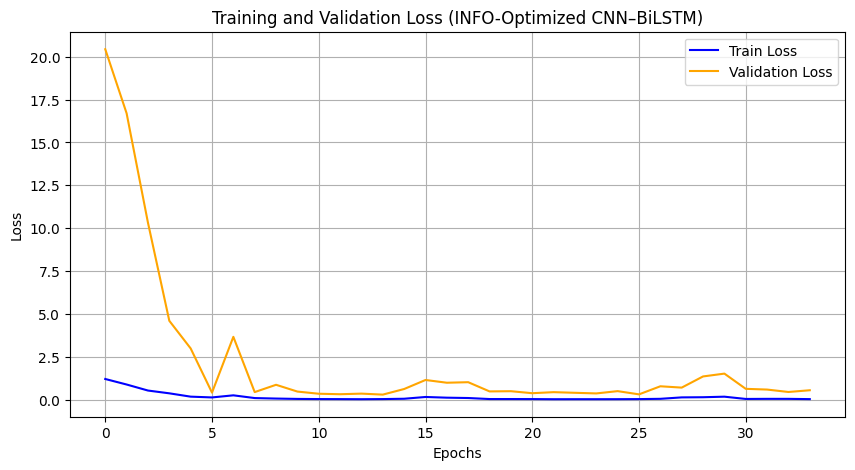

In [16]:
#Ploting Training vs Validation Loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss', color='blue')
plt.plot(val_losses, label='Validation Loss', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss (INFO-Optimized CNN–BiLSTM)')
plt.legend()
plt.grid(True)
plt.show()


Test Loss: 0.569106


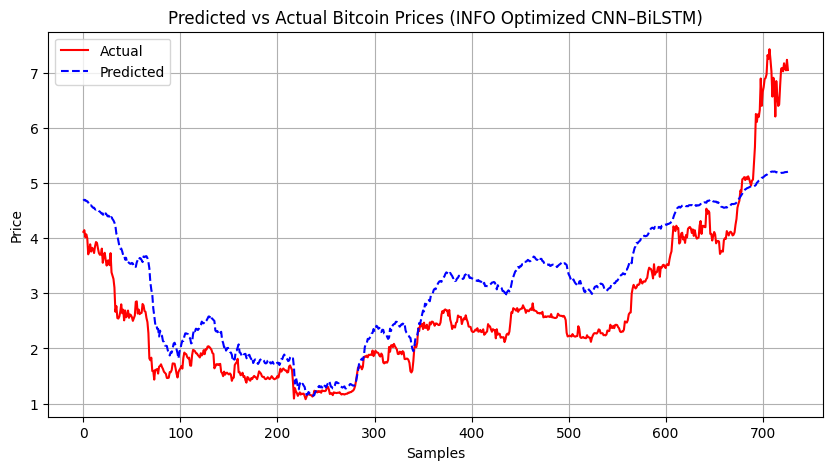

In [17]:
#Test Phase: Evaluate & Plot Predictions vs Actuals
model.eval()
test_loss = 0.0
test_predictions, test_targets = [], []

with torch.no_grad():
    for batch_x, batch_y in test_loader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)
        test_loss += loss.item()
        test_predictions.extend(outputs.cpu().numpy())
        test_targets.extend(batch_y.cpu().numpy())

avg_test_loss = test_loss / len(test_loader)
print(f"Test Loss: {avg_test_loss:.6f}")

test_predictions = np.array(test_predictions)
test_targets = np.array(test_targets)

plt.figure(figsize=(10, 5))
plt.plot(test_targets, label='Actual', color='red')
plt.plot(test_predictions, label='Predicted', color='blue', linestyle='--')
plt.xlabel('Samples')
plt.ylabel('Price')
plt.title('Predicted vs Actual Bitcoin Prices (INFO Optimized CNN–BiLSTM)')
plt.legend()
plt.grid(True)
plt.show()
